In [1]:
from alarms_analysis_utils import round_time_5, round_time_10, round_time_15, round_time_30, plot_time_of_day, plot_time_of_day_24_hours
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()  # Makes the graphs more beautiful :)
sns.set_theme(context='talk', style="whitegrid", palette="colorblind")
%matplotlib inline

In [2]:
# From: https://www.oref.org.il//Shared/Ajax/GetAlarmsHistory.aspx?lang=en&fromDate=07.11.2023&toDate=07.11.2023&mode=0

# Read Alarms.json and put all the data into a pandas dataframe:
with open('Alarms.json') as f:
    data = json.load(f) # Data includes only alarms that happened after 2023-10-07T08:57:00 (due to HomeFrontCommand API limitation)
    
df = pd.DataFrame(data)
df.head()

,data,date,time,alertDate,category,category_desc,matrix_id,rid
0,Nitzan,07.11.2023,17:01:10,2023-11-07T17:01:00,1,Missiles,1,24695
1,"Ashdod - Gimmel, Vav, Zain",07.11.2023,17:00:55,2023-11-07T17:01:00,1,Missiles,1,24693
2,Ashdod - Northern Industrial Zone and port,07.11.2023,17:00:55,2023-11-07T17:01:00,1,Missiles,1,24692
3,"Ashdod - Alef, Bet, Dalet, Heh",07.11.2023,17:00:54,2023-11-07T17:01:00,1,Missiles,1,24694
4,"Ashdod - Yod Alef, Yod Bet, Tet Vav, Yod Zain,...",07.11.2023,17:00:47,2023-11-07T17:01:00,1,Missiles,1,24691


In [3]:
# rename data column to "location":
df.rename(columns={'data': 'location'}, inplace=True)

# keep all rows that have category == 1:
df = df[df.category == 1]

# remove unnecessary columns:
df = df.drop(['category', 'category_desc', 'matrix_id'], axis=1)

# exclude alarms that happened on date 2023-10-07:
df = df[df.date != '07.10.2023']

# add a column named "time_rounded" that contains the time of the alarm rounded to the nearest x minutes:
rounding_minutes = 10 # change this to 5, 10, 15 or 30
rounding_func_name = f'round_time_{rounding_minutes}'
df['time_rounded'] = df['time'].apply(globals()[rounding_func_name])

# merge rows that have the same time_rounded, date and location. Add the rid column to the merged rows as list:
df = df.groupby(['time_rounded', 'date', 'location']).agg(
    rid = ('rid', list),
    count = ('rid', 'count')
).reset_index()

In [4]:
# print all the unique location:
df.location.unique()

array(['Erez', 'Nir- Um shooting range', 'Or HaNer',
       'Sderot, Ivim, Nir Am', 'Ashkelon - North', 'Ashkelon - South',
       'Ashkelon Northern Industrial Zone',
       'Ashkelon Southern Industrial Zone', 'Bat Hadar', "Be'er Ganim",
       'Kfar Silver', "Mavki'im", 'Holit', 'Mefalsim', "Zru'a",
       'Berekhya', 'Karmia', 'Mishan', 'Netiv HaAssara', 'Nir Israel',
       'Yad Mordechai', 'Sufa', 'Brosh', 'Maagalim, Givolim, Melilot',
       'NAM Industrial Zone ', 'Sharsheret', 'Shibolim', "Ta'ashur",
       'Tidhar', 'Kerem Shalom', 'Ein HaShlosha', 'Gavim, Sapir College',
       'Zikim', "Be'eri", 'Beit Shikma', 'Alumim', 'Kfar Azza',
       'Nachal Oz', "Sa'ad", 'Avshalom', 'Dekel', 'Sdeh Avraham', 'Yated',
       'Yevul', 'Kissufim', 'Misgav Am', 'Nirim', 'Nir Oz',
       'Mivtachim Amioz Yesha', 'Sdeh Eliezer', 'Magen', 'Ariel',
       'Bnei Dror', 'Even Yehuda', 'Geulim', 'Kadima - Zoran ',
       'Kfar Yona', "Kokhav Ya'ir - Tzur Yigal", 'Pardessiya', 'Salit',
       'Ta

In [5]:
# Create a new df of only alarms that happened in the merkaz area:
merkaz_df = df[df.location.isin(['Tel Aviv', 'Givatayim', 'Ramat Gan', 'Givat Shmuel', 'Bnei Brak', 'Petah Tikva', 'Rishon LeZion', 'Holon', 'Bat Yam', 'Ramat HaSharon', 'Herzliya', 'Kfar Saba', 'Ra\'anana', 'Hod HaSharon', 'Netanya', 'Ramla', 'Lod', 'Beit Dagan', 'Kfar Chabad', 'Mishmar HaShiva', 'Be\'er Yacov', 'Nir Zvi', 'Or Yehuda','Rosh HaAyin','Yehud-Monosson','Kiryat Ono', 'Ganei Tikva'])]
merkaz_df.head(500)

,time_rounded,date,location,rid,count
179,09:00,22.10.2023,Bat Yam,[23121],1
180,09:00,22.10.2023,Holon,[23122],1
380,11:30,14.10.2023,Bat Yam,[22124],1
381,11:30,14.10.2023,Beit Dagan,[22133],1
392,11:30,14.10.2023,Holon,[22131],1
...,...,...,...,...,...
3722,22:00,26.10.2023,Mishmar HaShiva,[23606],1
3724,22:00,26.10.2023,Nir Zvi,[23628],1
3725,22:00,26.10.2023,Or Yehuda,[23600],1
3730,22:00,26.10.2023,Ramla,[23611],1


In [6]:
# Group by location and count the number of alarms per location:
by_location_df = df.groupby('location').agg(count = ('location', 'count')).sort_values(by='count', ascending=False)
by_location_df.head(200)

,count
location,
Ashkelon Southern Industrial Zone,109
Netiv HaAssara,97
"Sderot, Ivim, Nir Am",86
Ashkelon - South,80
Zikim,74
...,...
Misgav Dov,4
Neveh Mivtach,4
Nahariya,4


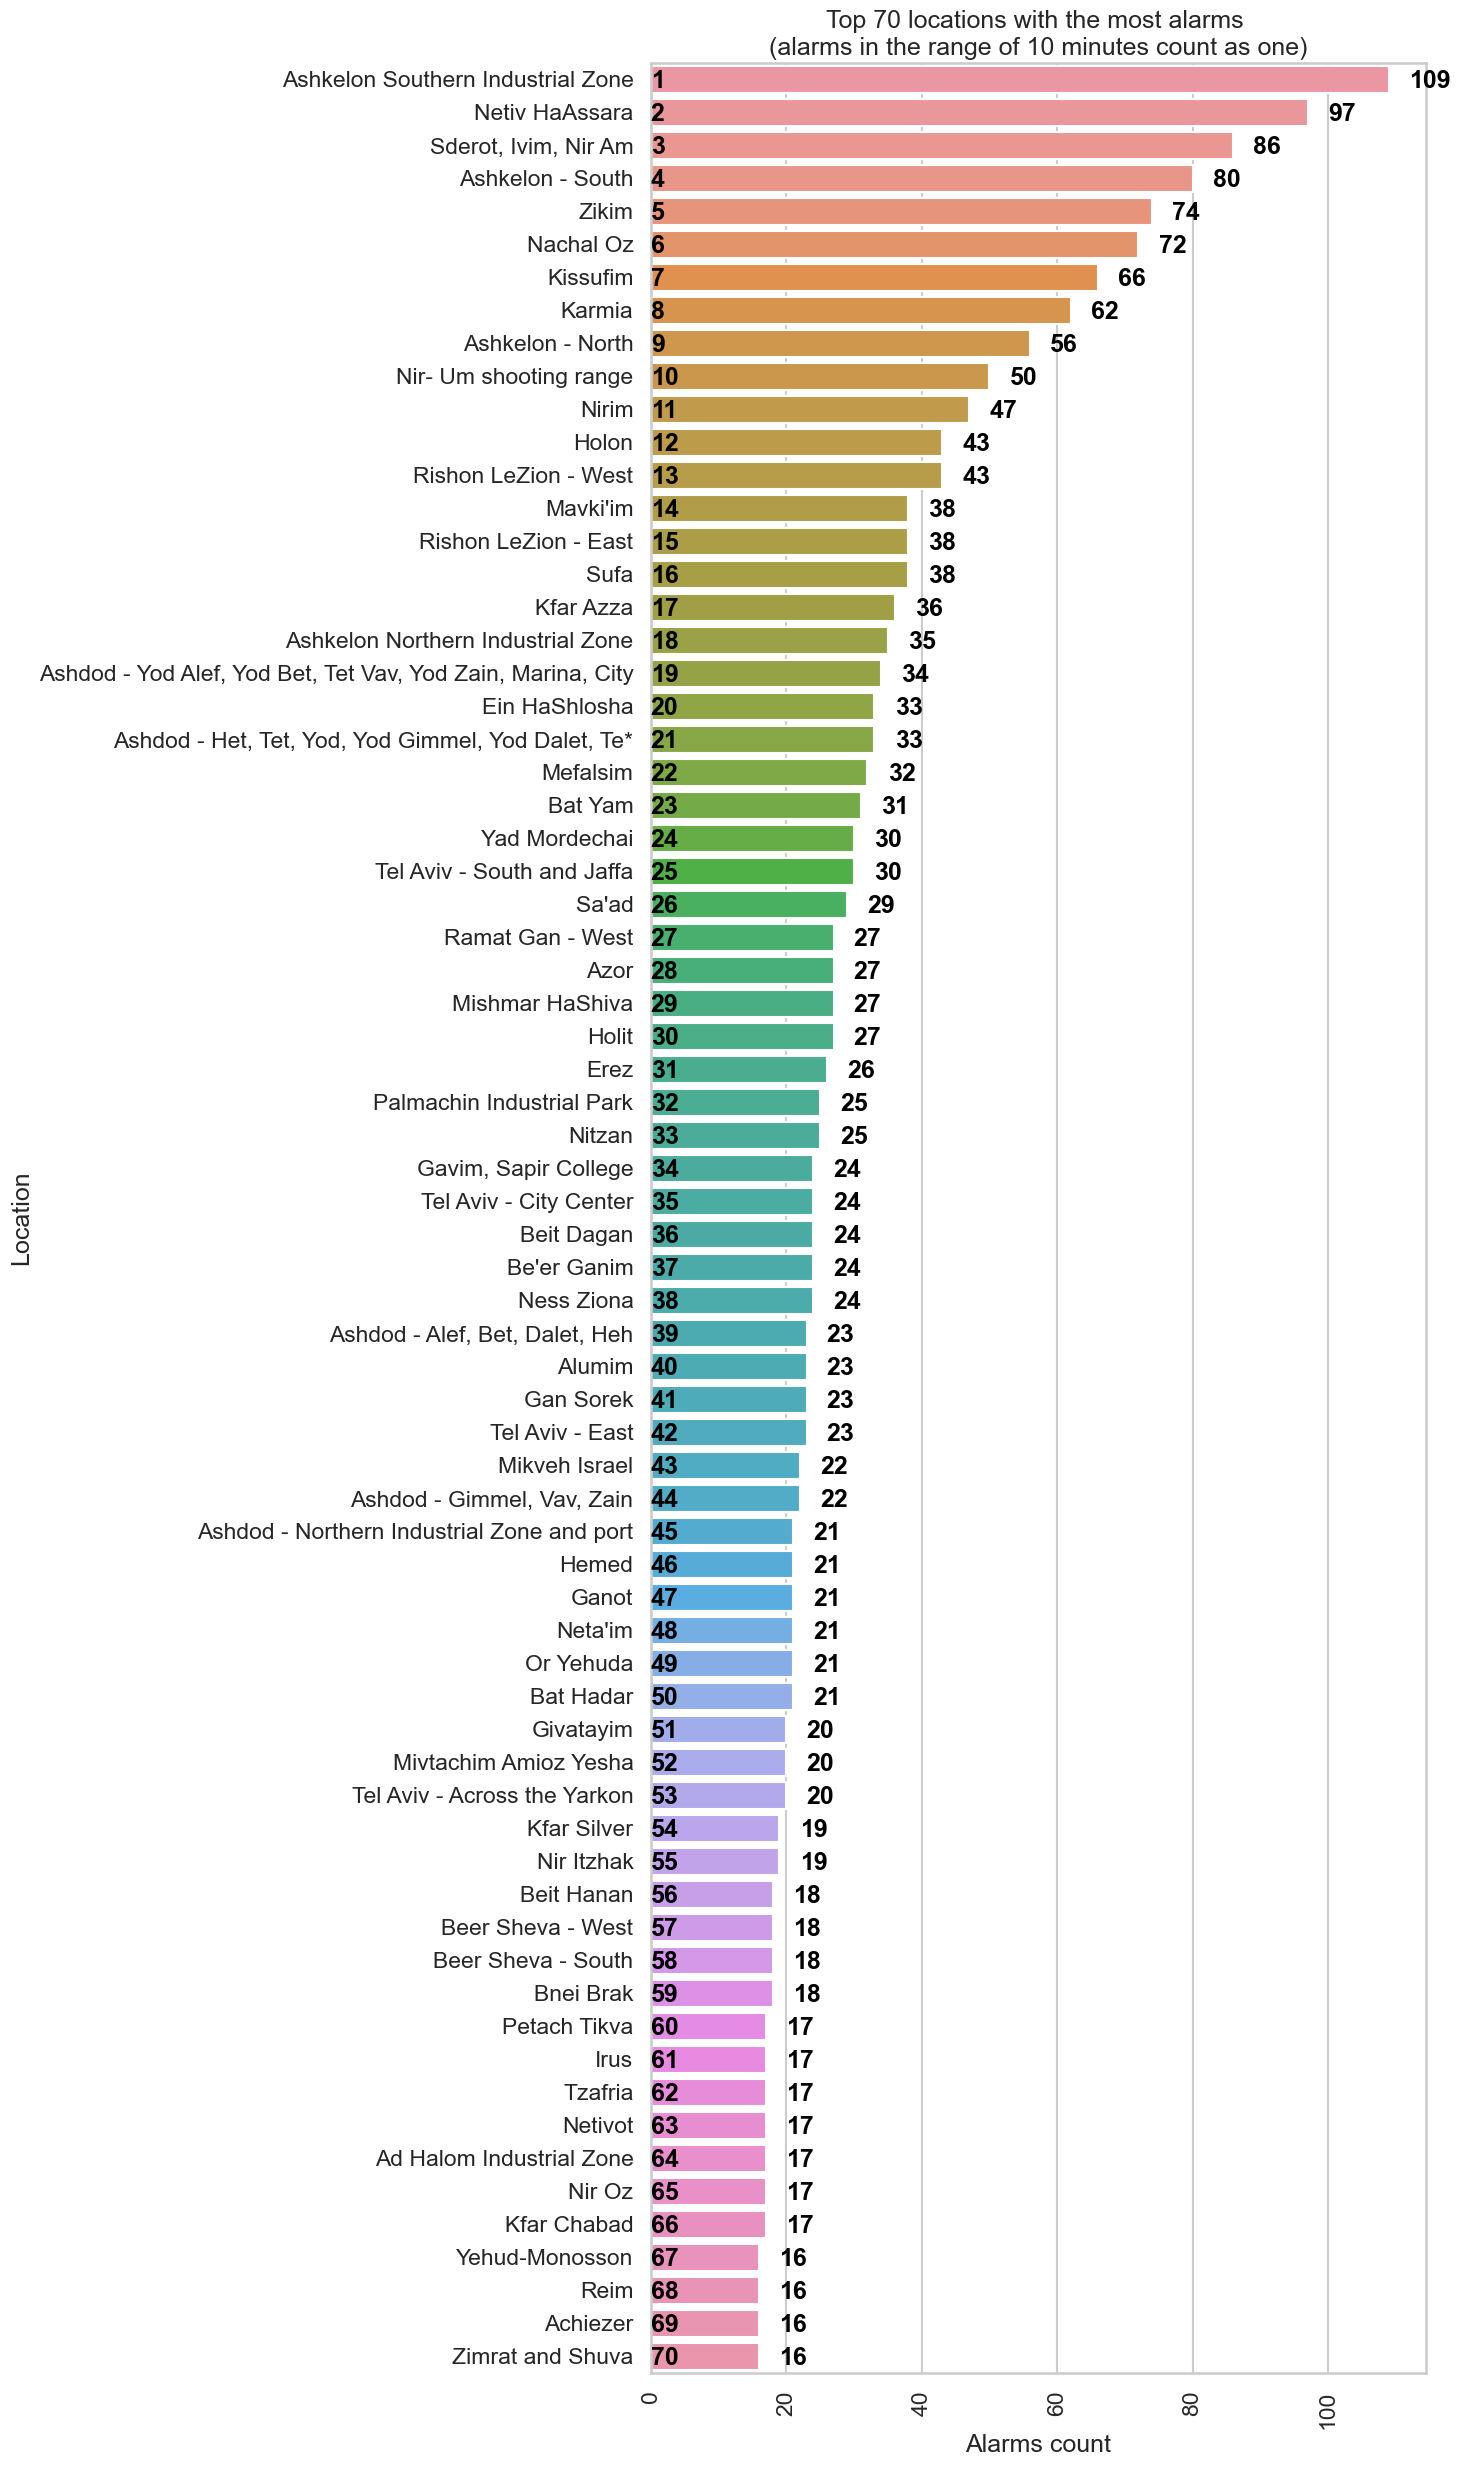

In [7]:
# Visualize the top 50 locations with the most alarms using a horizontal bar chart (use seaborn):
plt.figure(figsize=(10, 30))
limit = 70
sns.barplot(x=by_location_df['count'][:limit], y=by_location_df.index[:limit], orient='h')
plt.xticks(rotation=90)
# Add value labels on bars:
for i, v in enumerate(by_location_df['count'][:limit]):
    plt.text(v + 3, i + .25, str(v), color='black', fontweight='bold')
    
# Add the index of the location on the y axis labels (1. <location_name>):
for i, v in enumerate(by_location_df.index[:limit]):
    plt.text(0, i + .25, str(i + 1), color='black', fontweight='bold')

plt.xlabel('Alarms count')
plt.ylabel('Location')
plt.title(f'Top {limit} locations with the most alarms \n(alarms in the range of {rounding_minutes} minutes count as one)')

plt.show()

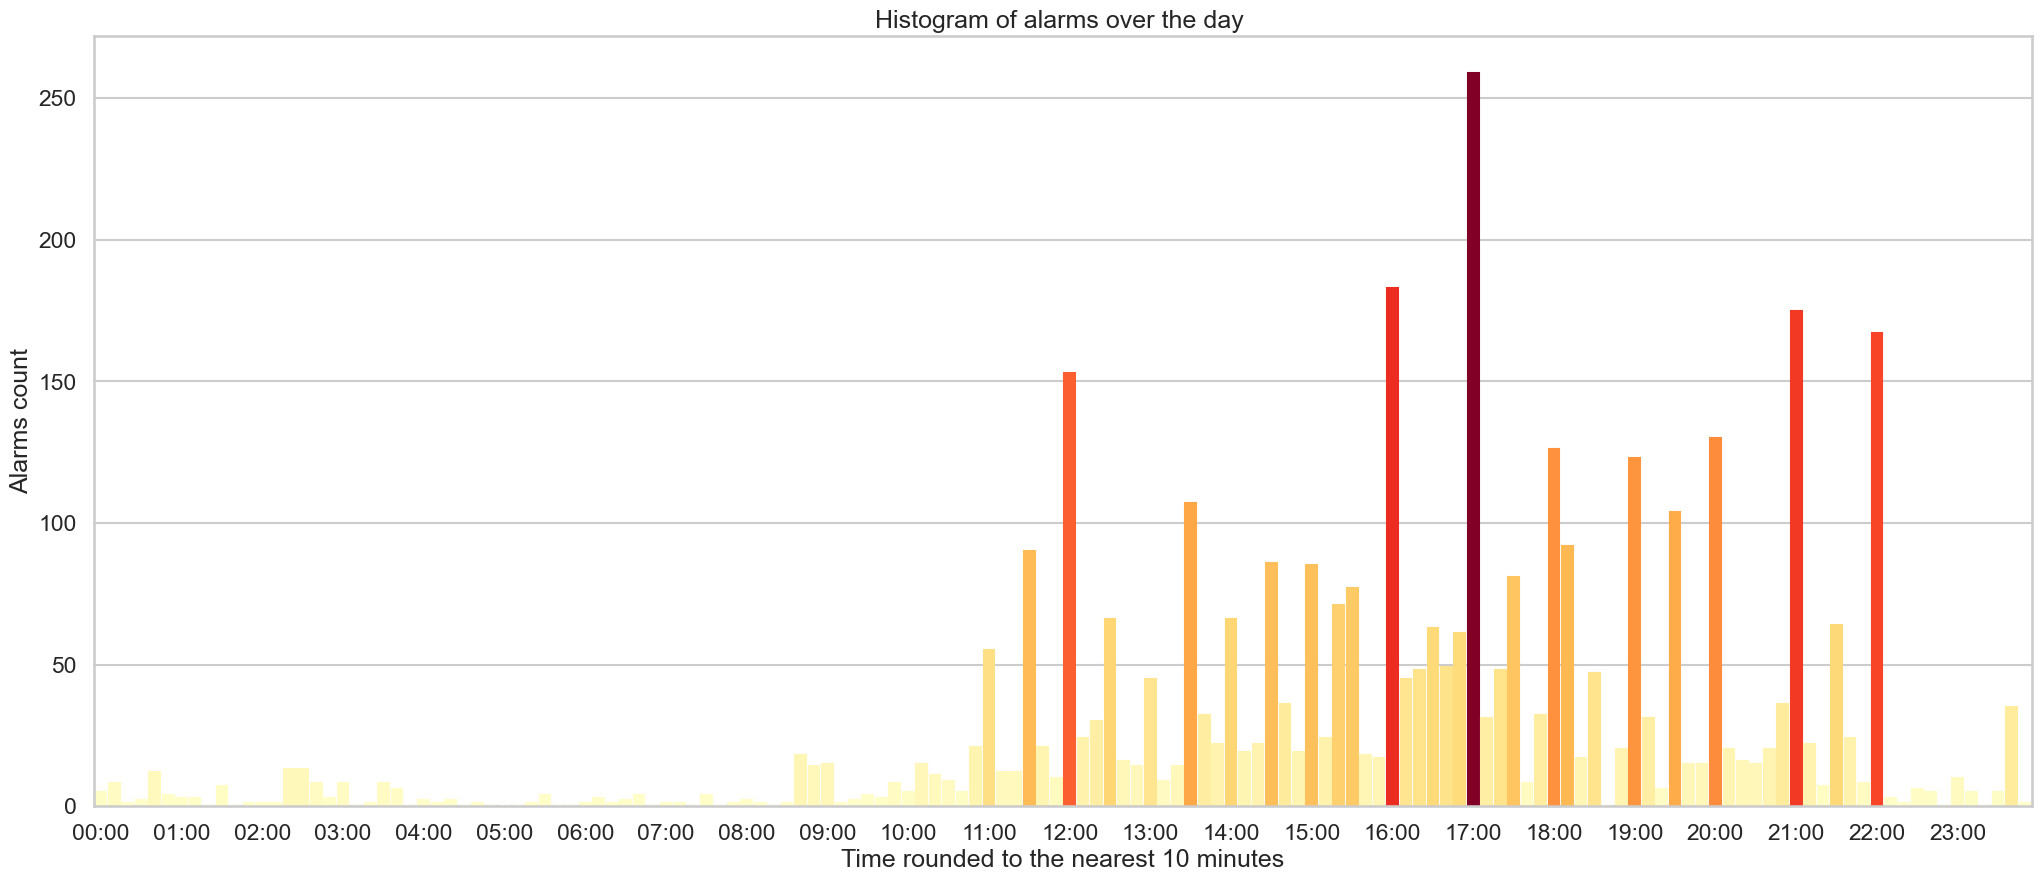

In [59]:
# %load_ext autoreload
# %autoreload 1

%aimport alarms_analysis_utils
# Visualize the number of alarms per time_rounded using a horizontal bar chart (use seaborn):
plot_time_of_day_24_hours(df, rounding_minutes)

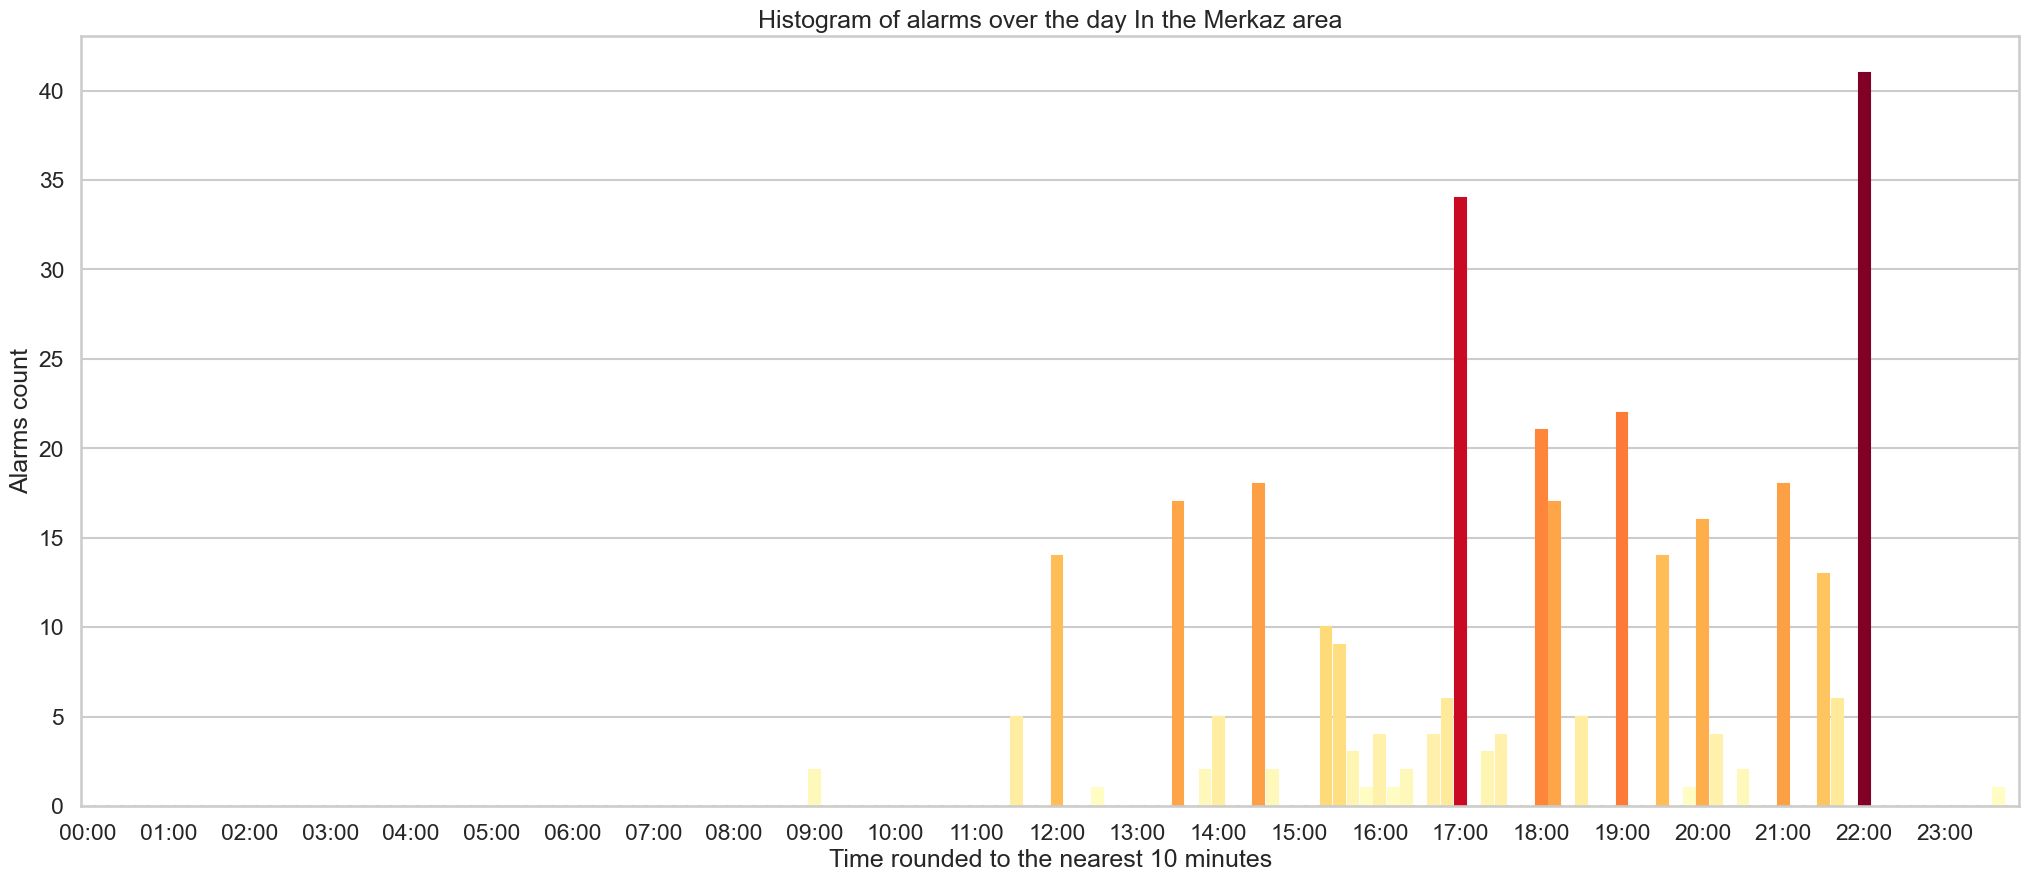

In [60]:
# plot_time_of_day(merkaz_df, rounding_minutes, 'In the Merkaz area')
plot_time_of_day_24_hours(merkaz_df, rounding_minutes, 'In the Merkaz area')

In [10]:
# Create a new dataframe that contains all the unique locations:
# locations_list = df['location'].tolist()
# locations_map = {}
# locations_list


In [11]:
# Enrich the df with the lat and lng of each location:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="alarms_analysis")
# 
# 
# def get_lat_lng(_location):
#     global locations_map
#     try:
#         location_res = geolocator.geocode(_location)
#         print(f'Got location for: {_location}')
#         locations_map[_location] = location_res
#     except:
#         print(f'Failed to get lat and lng for location: {_location}')
#         return None, None
# 
# for location in locations_list:
#     if location not in locations_map:
#         get_lat_lng(location)


In [12]:
# # remove from locations_map all the keys that have value None:
# locations_map_filtered = {k: v for k, v in locations_map.items() if v is not None}
# 
# # remove from locations_map all the keys that have does not have the word "ישראל" in their address value:
# locations_map_filtered = {k: v for k, v in locations_map_filtered.items() if 'ישראל' in v.address}

In [13]:
# Save locations_map_filtered to a json file:

# First make it json serializable:
# locations_map_serializable = {}
# 
# for k, v in locations_map_filtered.items():
#     locations_map_serializable[k] = {
#         'latitude': v.latitude,
#         'longitude': v.longitude,
#         'address': v.address
#     }
# 
# # Save to json file:
# with open('locations_map_filtered.json', 'w') as f:
#     json.dump(locations_map_serializable, f)


In [14]:
# Read locations_map_filtered from json file:
with open('locations_map_filtered.json') as f:
    locations_map_filtered = json.load(f)


In [15]:
locations_map_filtered

{'Erez': {'latitude': 31.5605003,
  'longitude': 34.5666313,
  'address': 'ארז, מועצה אזורית שער הנגב, נפת אשקלון, מחוז הדרום, ישראל'},
 'Or HaNer': {'latitude': 31.5575591,
  'longitude': 34.6000531,
  'address': 'אור הנר, מועצה אזורית שער הנגב, נפת אשקלון, מחוז הדרום, ישראל'},
 'Ashkelon - North': {'latitude': 31.681007,
  'longitude': 34.610007,
  'address': 'צומת אשקלון צפון, 4, שירת הים, מועצה אזורית חוף אשקלון, נפת אשקלון, מחוז הדרום, 7928900, ישראל'},
 'Ashkelon - South': {'latitude': 31.6644874,
  'longitude': 34.5730157,
  'address': 'אשקלון, נפת אשקלון, מחוז הדרום, ישראל'},
 'Ashkelon Northern Industrial Zone': {'latitude': 31.675934,
  'longitude': 34.6044924,
  'address': 'אשקלון, הרכבת, אזור התעשיה הצפוני, אשקלון, נפת אשקלון, מחוז הדרום, 7859700, ישראל'},
 'Ashkelon Southern Industrial Zone': {'latitude': 31.6355602,
  'longitude': 34.5562263,
  'address': 'אזור התעשיה הדרומי, אשקלון, נפת אשקלון, מחוז הדרום, 7888909, ישראל'},
 'Bat Hadar': {'latitude': 31.646519,
  'longit

In [16]:
def get_lat(x):
    return_val = locations_map_filtered[x]['latitude'] if x in locations_map_filtered else None
    if return_val is None:
        print(f'Failed to get lat for location: {x}')
    return return_val


# Enrich df with lat and lng based on locations_map (if location is not in locations_map, lat and lng will be None):
df['lat'] = df['location'].apply(lambda x: get_lat(x))
df['lng'] = df['location'].apply(lambda x: locations_map_filtered[x]['longitude'] if x in locations_map_filtered else None)
df.head()

Failed to get lat for location: Nir- Um shooting range
Failed to get lat for location: Sderot, Ivim, Nir Am
Failed to get lat for location: Sderot, Ivim, Nir Am
Failed to get lat for location: Mishan
Failed to get lat for location: Netiv HaAssara
Failed to get lat for location: Nir- Um shooting range
Failed to get lat for location: Sderot, Ivim, Nir Am
Failed to get lat for location: Sufa
Failed to get lat for location: Netiv HaAssara
Failed to get lat for location: Netiv HaAssara
Failed to get lat for location: Sufa
Failed to get lat for location: Brosh
Failed to get lat for location: Maagalim, Givolim, Melilot
Failed to get lat for location: Kerem Shalom
Failed to get lat for location: Kerem Shalom
Failed to get lat for location: Gavim, Sapir College
Failed to get lat for location: Netiv HaAssara
Failed to get lat for location: Sderot, Ivim, Nir Am
Failed to get lat for location: Netiv HaAssara
Failed to get lat for location: Sderot, Ivim, Nir Am
Failed to get lat for location: Sa'ad

,time_rounded,date,location,rid,count,lat,lng
0,00:00,08.10.2023,Erez,[20557],1,31.560500,34.566631
1,00:00,08.10.2023,Nir- Um shooting range,[20558],1,NaN,NaN
2,00:00,08.10.2023,Or HaNer,[20556],1,31.557559,34.600053
3,00:00,08.10.2023,"Sderot, Ivim, Nir Am",[20555],1,NaN,NaN
4,00:00,30.10.2023,"Sderot, Ivim, Nir Am",[23991],1,NaN,NaN


In [17]:
# Create a heat map of the alarms over the map of israel:
import folium
from folium.plugins import HeatMap


# Create a map:
m = folium.Map(location=[31.0461, 34.8516], zoom_start=7)

# Add a heatmap to the map:
HeatMap(data=df[['lat', 'lng', 'count']].groupby(['lat', 'lng']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(m)

# Display the map:
m

In [18]:
# Get all the locations that have NaN lat and lng sorted alphabetically:
df[df['lat'].isna()]['location'].sort_values().unique()

array(['Adi', 'Afek and Lev Ha"aretz Industrial Zone', 'Ahisemech',
       'Al Azi', 'Al Khawaled - West', 'Alfei Menashe', 'Alkosh', 'Alma',
       'Alon Shvut', 'Aluma', 'Amuka', 'Ariel',
       'Ashdod - Alef, Bet, Dalet, Heh', 'Ashdod - Gimmel, Vav, Zain',
       'Ashdod - Het, Tet, Yod, Yod Gimmel, Yod Dalet, Te*',
       'Ashdod - Northern Industrial Zone and port',
       'Ashdod - Yod Alef, Yod Bet, Tet Vav, Yod Zain, Marina, City',
       'Asseret', 'Avigdor', 'Bat Ayin', "Be'er Yacov", "Be'erot Itzhak",
       'Beer Sheva - East', 'Beer Sheva - North', 'Beer Sheva - West',
       'Beit HaGdi', "Beit Shea'rim", 'Beitar Illit', 'Biriyeh',
       'Bnei Darom Compound', 'Bnei Yehuda and Givat Yoav', 'Brosh',
       'Cabri', 'Dalton', 'Dan', 'Daniel', 'Dudaim Site', 'Efrat',
       'Ein Kerem Boarding School', 'Ein Quiniyye', 'Ein Shemer',
       'El-Sid', 'Elazar', 'Elkana', 'Etz Ephraim', 'Ezer', "Ga'ash",
       'Ganei Tal', 'Ganei Yochanan', 'Ganot', 'Gavim, Sapir College',
  